In [3]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 51kB/s 
     |████████████████████████████████| 3.8MB 43.9MB/s 
     |████████████████████████████████| 450kB 54.7MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [4]:
import os
import nltk
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from matplotlib import pyplot as plt
import json
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import csv
import zipfile

Using TensorFlow backend.


In [5]:
tf.__version__

'2.0.0'

In [0]:
# !wget https://storage.googleapis.com/columbia_landmarks/glove_50.zip  \
#     -O /tmp/RawData1.zip

In [0]:
# local_zip = '/tmp/RawData1.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

In [8]:
from google.colab import files
uploaded = files.upload()

Saving glove.twitter.27B.50d.txt.zip to glove.twitter.27B.50d.txt.zip


In [9]:
!ls -al

total 204440
drwxr-xr-x 1 root root      4096 Mar  2 00:53 .
drwxr-xr-x 1 root root      4096 Mar  2 00:49 ..
drwxr-xr-x 1 root root      4096 Feb 19 17:12 .config
-rw-r--r-- 1 root root 209323095 Mar  2 01:12 glove.twitter.27B.50d.txt.zip
drwxr-xr-x 1 root root      4096 Feb  5 18:37 sample_data


In [0]:
local_zip = 'glove.twitter.27B.50d.txt.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [11]:
embeddings_index = {}
f = open('/tmp/glove.twitter.27B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [12]:
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv

--2020-03-02 01:14:09--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6523814 (6.2M) [text/plain]
Saving to: ‘articles_train.csv’

articles_train.csv  100%[===================>]   6.22M  --.-KB/s    in 0.06s   

2020-03-02 01:14:09 (99.6 MB/s) - ‘articles_train.csv’ saved [6523814/6523814]

--2020-03-02 01:14:10--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:

In [13]:
!ls -al

total 212288
drwxr-xr-x 1 root root      4096 Mar  2 01:14 .
drwxr-xr-x 1 root root      4096 Mar  2 00:49 ..
-rw-r--r-- 1 root root   1509129 Mar  2 01:14 articles_test.csv
-rw-r--r-- 1 root root   6523814 Mar  2 01:14 articles_train.csv
drwxr-xr-x 1 root root      4096 Feb 19 17:12 .config
-rw-r--r-- 1 root root 209323095 Mar  2 01:12 glove.twitter.27B.50d.txt.zip
drwxr-xr-x 1 root root      4096 Feb  5 18:37 sample_data


In [0]:
df_train = pd.read_csv('articles_train.csv')
df_test = pd.read_csv('articles_test.csv')

In [0]:
text = df_train['content_body_clean']

In [16]:
type(text)

pandas.core.series.Series

In [0]:
t = Tokenizer()
t.fit_on_texts(text)

sequence_length = 500


train = t.texts_to_sequences(text)
num_words = len(t.word_index)+1
max_features = num_words
x_train = pad_sequences(train, maxlen=sequence_length, padding='post')
y_train = np.array(df_train['blind_mean_rating'])

In [18]:
len(train)
# !wc -l articles_train.csv
# tokenized[0]


# i = len(train[0])
# for j in range(len(train)):
#   if len(train[j]) > i:
#     i = len(train[j])
#     print(i)

i = len(x_train[0])
for j in range(len(x_train)):
  if len(x_train[j]) > i:
    i = len(x_train[j])
print(i)


500


In [0]:
y_train = np.array(df_train['blind_mean_rating'])

In [20]:
y_train[0]

3.1777777777777776

In [21]:
word_index = t.word_index
print('Found %s unique tokens.' % len(word_index))

Found 38128 unique tokens.


In [22]:

print(num_words)

embedding_dim = 50

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

38129


In [0]:
from keras.initializers import Constant

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile('adam', loss='mse')
model.summary()

# model.add(Dropout(0.25))
# model.add(Dense(units=5, activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())
# model = Sequential()
# model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
# model.add(TimeDistributed(Dense(1, activation='sigmoid')))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# # train LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 50)           1906450   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,973,651
Trainable params: 1,973,651
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

Train on 1040 samples, validate on 261 samples
Epoch 1/100
1040/1040 [==============================] - 20s 19ms/sample - loss: 2.8559 - val_loss: 0.9812
Epoch 2/100
1040/1040 [==============================] - 17s 16ms/sample - loss: 0.7604 - val_loss: 0.9388
Epoch 3/100
1040/1040 [==============================] - 17s 16ms/sample - loss: 0.7357 - val_loss: 0.9632
Epoch 4/100
1040/1040 [==============================] - 17s 16ms/sample - loss: 0.7181 - val_loss: 0.9273
Epoch 5/100
1040/1040 [==============================] - 16s 16ms/sample - loss: 0.6712 - val_loss: 0.9632
Epoch 6/100
1040/1040 [==============================] - 17s 16ms/sample - loss: 0.6249 - val_loss: 0.9186
Epoch 7/100
1040/1040 [==============================] - 17s 16ms/sample - loss: 0.5446 - val_loss: 0.9816
Epoch 8/100
1040/1040 [==============================] - 17s 16ms/sample - loss: 0.4402 - val_loss: 1.0201
Epoch 9/100
1040/1040 [==============================] - 16s 16ms/sample - loss: 0.3352 - val_los

In [0]:
test = t.texts_to_sequences(df_test['content_body_clean'])
x_test = pad_sequences(test, maxlen=sequence_length, padding='post')
y_test = np.array(df_test['blind_mean_rating'])

In [27]:
loss = model.evaluate(x_test, y_test)
print('Model Test Loss: {0:.4f}'.format(loss))

326/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

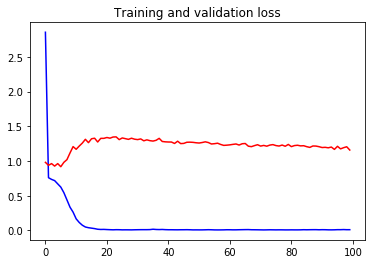

In [28]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Training and validation loss')
plt.show()

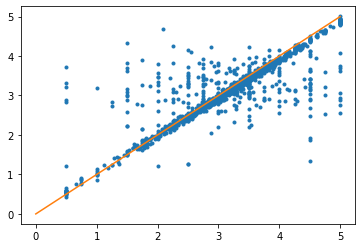

In [29]:
### Training dataset Predictions

y_pred = model.predict(x_train)

plt.plot(y_train, y_pred, '.')

# # plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 5)
y = x
plt.plot(x, y)
plt.show()

In [30]:
y_pred = y_pred.reshape(y_pred.shape[0])
d = y_train - y_pred
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(np.sum(d**2)/np.sum((y-np.mean(y))**2))

print("RESULTS...")
print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

RESULTS...
MAE: 0.23375662700019276
MSE: 0.24240561837525582
RMSE: 0.49234705074292445
R-Squared: -1.9088217912101988


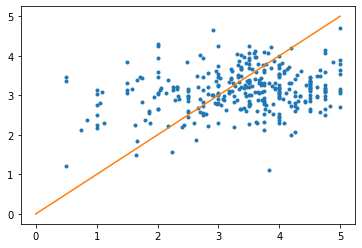

In [31]:
## Test Data Prediction
y_pred = model.predict(x_test)

plt.plot(y_test, y_pred, '.')

# # plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 5)
y = x
plt.plot(x, y)
plt.show()

In [32]:
y_pred = y_pred.reshape(y_pred.shape[0])
d = y_test - y_pred
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(np.sum(d**2)/np.sum((y-np.mean(y))**2))
print("RESULTS...")
print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

RESULTS...
MAE: 0.8468305016545729
MSE: 1.0997444858453753
RMSE: 1.0486870295018316
R-Squared: -2.306789349062404
